In [1]:
from FastCCM import CCM
from FastCCM.utils import utils
from FastCCM.data.data_loader import get_truncated_lorenz_rand, get_truncated_rossler_lorenz_rand
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

In [2]:
ccm = CCM.PairwiseCCM(device="cpu")

**CCM for joint Rossler-Lorenz attractor**

In [46]:
X = get_truncated_rossler_lorenz_rand(500,50000,alpha=4, C=2)

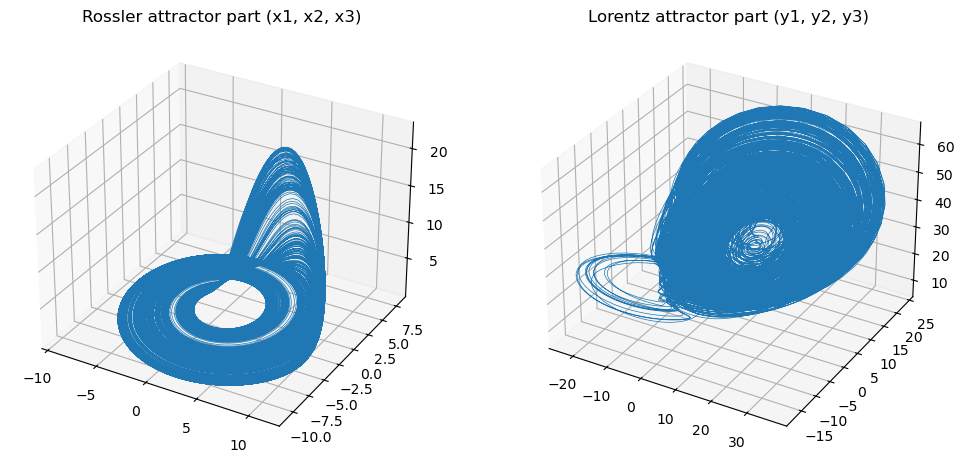

In [47]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(*X[:,[0, 1, 2]].T, lw=0.5)
ax1.set_title('Rossler attractor part (x1, x2, x3)')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(*X[:, [4, 3, 5]].T, lw=0.5)
ax2.set_title('Lorentz attractor part (y1, y2, y3)')

plt.show()

(non-time-delay-embedded) Lorenz xmap Rossler

In [48]:
ccm.compute(X[:,:3][None],X[:,3:][None],5000,500,50,20,0).mean()

0.7037341

(non-time-delay-embedded) Rossler xmap Lorentz

In [49]:
ccm.compute(X[:,3:][None],X[:,:3][None],5000,500,50,20,0).mean()

0.5604895

Demonstration of convergence and variation of approximation

In [87]:
sizes = [80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480]

res_p_XY = []
for i in sizes:
    for e in range(20):
        res_p_XY += [ccm.compute(X[:,:3][None],X[:,3:][None],20000,i,20,10,0).mean()]
res_p_XY = np.array(res_p_XY).reshape(-1,20)

res_p_YX= []
for i in sizes:
    for e in range(20):
        res_p_YX += [ccm.compute(X[:,3:][None],X[:,:3][None],20000,i,20,10,0).mean()]
res_p_YX = np.array(res_p_YX).reshape(-1,20)

In [88]:
res_l_XY = []
for i in sizes:
    for e in range(20):
        res_l_XY += [ccm.compute(X[:,:3][None],X[:,3:][None],i,20000,20,10,0).mean()]
res_l_XY = np.array(res_l_XY).reshape(-1,20)

res_l_YX = []
for i in sizes:
    for e in range(20):
        res_l_YX += [ccm.compute(X[:,3:][None],X[:,:3][None],i,20000,20,10,0).mean()]
res_l_YX = np.array(res_l_YX).reshape(-1,20)

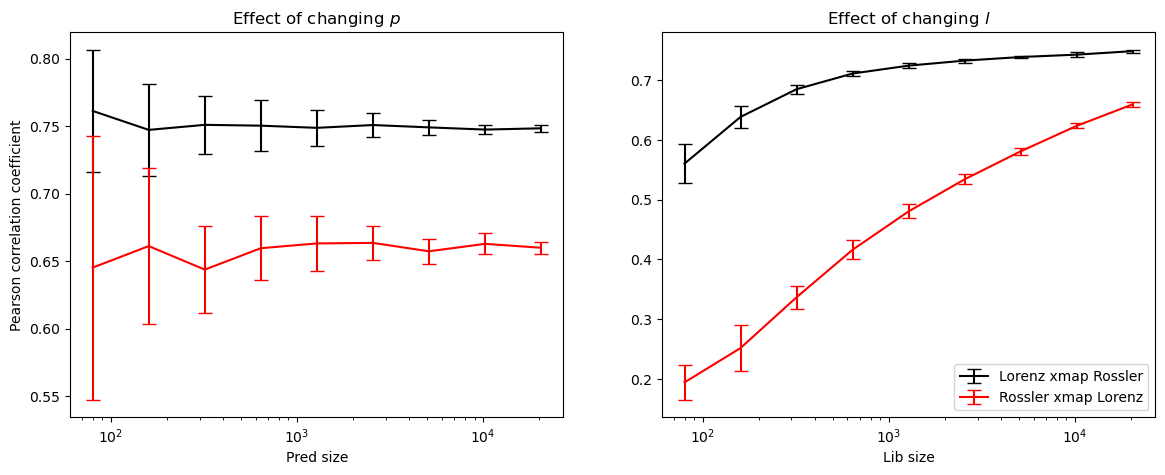

In [125]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title("Effect of changing $p$")
plt.errorbar(sizes,res_p_XY.mean(axis=1),yerr=res_p_XY.std(axis=1),capsize=5, color="black", label="Lorenz xmap Rossler")
plt.errorbar(sizes,res_p_YX.mean(axis=1),yerr=res_p_YX.std(axis=1),capsize=5, color="red", label="Rossler xmap Lorenz")
plt.ylabel("Pearson correlation coefficient")
plt.xlabel("Pred size")
plt.xscale("log")

plt.subplot(1,2,2)
plt.title("Effect of changing $l$")
plt.errorbar(sizes,res_l_XY.mean(axis=1),yerr=res_l_XY.std(axis=1),capsize=5, color="black", label="Lorenz xmap Rossler" )
plt.errorbar(sizes,res_l_YX.mean(axis=1),yerr=res_l_YX.std(axis=1),capsize=5, color="red", label="Rossler xmap Lorenz" )
plt.xscale("log")
plt.xlabel("Lib size")
plt.legend()

**5 independent Lorentz systems, each coordinate time delay embedded into 5 dimensions. All pairwise CCM.**

In [35]:
N_sys = 5

# Generate X axes of Lorenz systems starting from different initial state
X = np.concatenate([get_truncated_lorenz_rand(280,n_steps=30000).T for i in range(N_sys)])

X_emb = [utils.get_td_embedding_np(x[:,None],5,30,return_pred=False)[:,:,0] for x in X]

In [36]:
np.array(X_emb).shape

(15, 29880, 5)

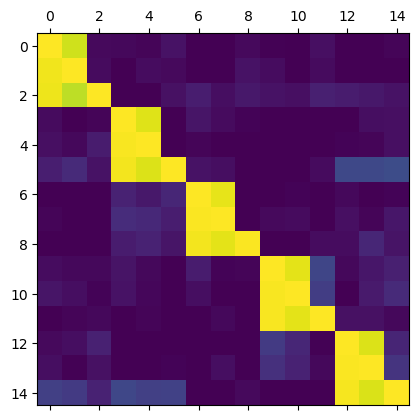

In [38]:
plt.matshow(ccm.compute(X_emb,X_emb,2000,500,30,5,0)[0],vmax=1,vmin=0)

**Finding a prediction power for a range of Tp**

In [66]:
X = get_truncated_lorenz_rand(280,n_steps=30000)[None]
Y = X[:,:,[0]]

In [67]:
X.shape, Y.shape

((1, 30000, 3), (1, 30000, 1))

The naive way

2.177140951156616 sec


Text(0, 0.5, 'Rho')

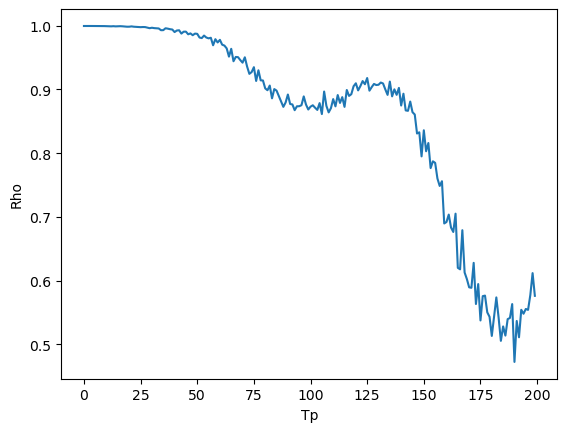

In [68]:
st = time.time()
res = [ccm.compute(X,Y,5000,1000,50,50,i)[0,0,0] for i in range(200)]
print(time.time()-st, "sec")
plt.plot(res)
plt.xlabel("Tp")
plt.ylabel("Rho")

The smart way

In [86]:
interval = 200
X_ = X[:,:-(interval-1)]
Y_ = utils.get_td_embedding_np(Y[0],interval,1)[:,:,0].T[:,:,None]
X_.shape, Y_.shape

((1, 29801, 3), (200, 29801, 1))

0.03505730628967285 sec


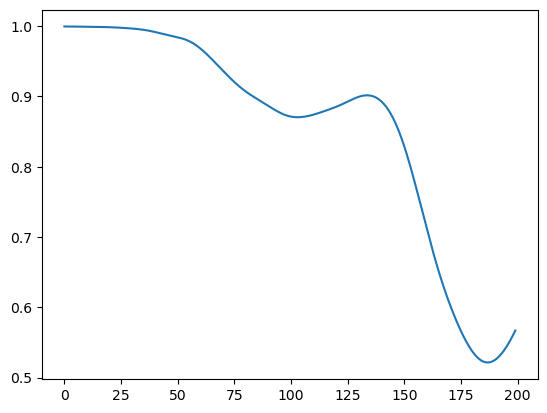

In [91]:
st = time.time()
res = ccm.compute(X_,Y_,5000,1000,50,50,0)[0,:,0]
print(time.time()-st, "sec")
plt.plot(res)

**Prediction horizon with different subset sizes**

In [ ]:
exp_num = 20
tmax = 4000
n_steps = 200000
interval = 250
sample_size = 500
subset_sizes = np.arange(1000,50000,1000)

exp_res = []
for i in range(exp_num):
    X = get_truncated_lorenz_rand(tmax,n_steps=n_steps)[None]
    Y = X[:,:,[0]]

    X_ = X[:,:-(interval-1)]
    Y_ = utils.get_td_embedding_np(Y[0],interval,1)[:,:,0].T[:,:,None]

    res = np.array([ccm.compute(X_,Y_,i,sample_size,20,20,0)[0,:,0] for i in subset_sizes])
    exp_res += [res]
exp_res = np.array(exp_res).mean(axis=0)

/tmp/ipykernel_4645/1696074535.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', subset_sizes.shape[0])


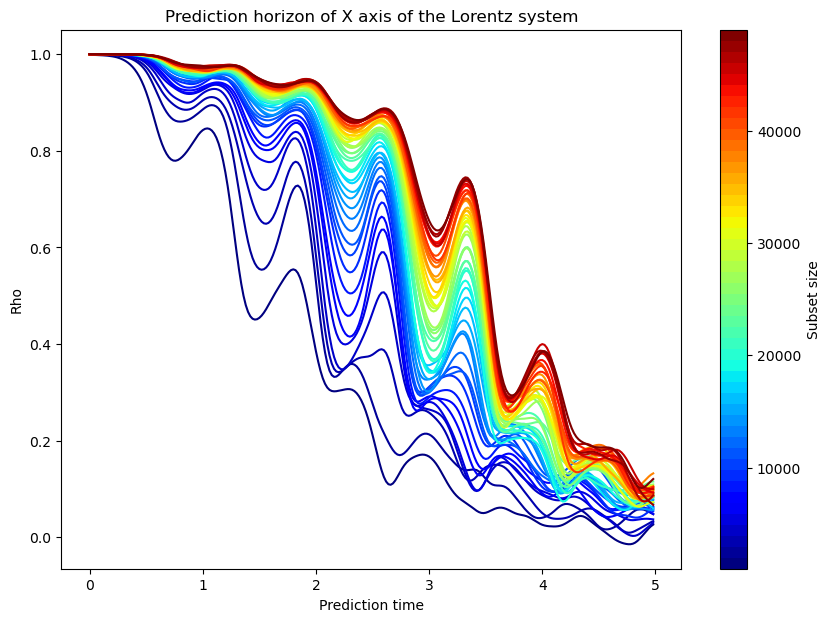

In [42]:
fig, ax = plt.subplots(figsize=(10, 7))
cmap = cm.get_cmap('jet', subset_sizes.shape[0])
norm = plt.Normalize(subset_sizes.min(), subset_sizes.max())

for i in range(exp_res.shape[0]):
    ax.plot(tmax/n_steps * np.arange(interval), exp_res[i], color=cmap(i))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Subset size')

ax.set_xlabel("Prediction time")
ax.set_ylabel("Rho")
plt.title("Prediction horizon of X axis of the Lorentz system")
plt.show()

In [41]:
exp_num = 20
tmax = 4000
n_steps = 200000
interval = 250
sample_size = 500
subset_sizes = np.arange(1000,50000,1000)

exp_res = []
for i in range(exp_num):
    X = get_truncated_lorenz_rand(tmax,n_steps=n_steps)[None]
    Y = X[:,:,[0]]

    X_ = X[:,:-(interval-1)]
    Y_ = utils.get_td_embedding_np(Y[0],interval,1)[:,:,0].T[:,:,None]
    X_ = utils.get_td_embedding_np(X_[0],3,2).reshape(-1,3*3)[None]

    res = np.array([ccm.compute(X_,Y_,i,sample_size,20,20,0)[0,:,0] for i in subset_sizes])
    exp_res += [res]
exp_res = np.array(exp_res).mean(axis=0)

/tmp/ipykernel_4645/3646813403.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', subset_sizes.shape[0])


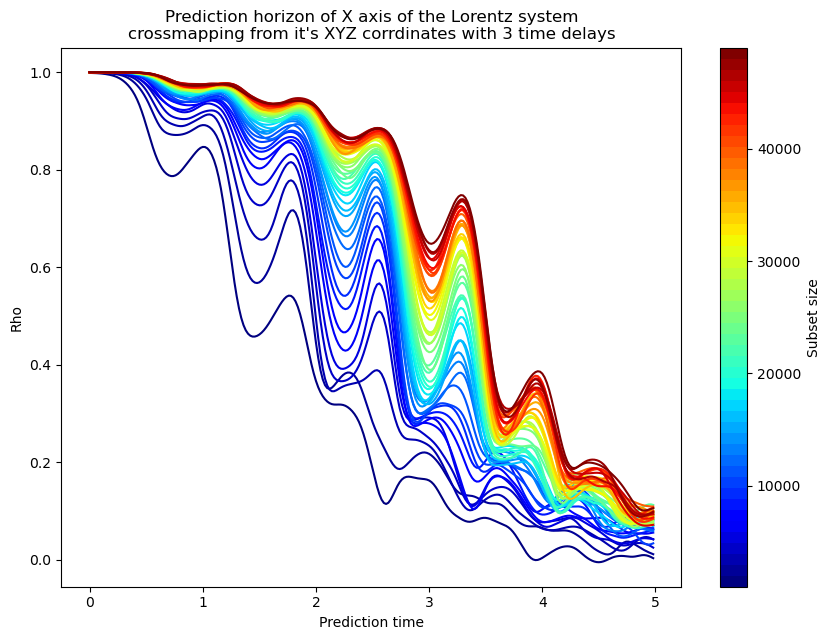

In [40]:
fig, ax = plt.subplots(figsize=(10, 7))
cmap = cm.get_cmap('jet', subset_sizes.shape[0])
norm = plt.Normalize(subset_sizes.min(), subset_sizes.max())

for i in range(exp_res.shape[0]):
    ax.plot(tmax/n_steps * np.arange(interval), exp_res[i], color=cmap(i))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Subset size')

ax.set_xlabel("Prediction time")
ax.set_ylabel("Rho")
plt.title("Prediction horizon of X axis of the Lorentz system\ncrossmapping from it's XYZ corrdinates with 3 time delays")
plt.show()

In [59]:
X = get_truncated_lorenz_rand(800,n_steps=40000)

In [73]:
Z_embs = np.concatenate(np.array([[utils.get_td_embedding_np(X[:,[2]],i,j)[:,:,0] for i in range(1,40)] for j in range(1,40)],dtype="object"))

In [89]:
ccm = CCM.PairwiseCCM("cpu")

res = ccm.compute(Z_embs, X[:,0][None,:,None],
            5200,1200,30,20,0
                 )

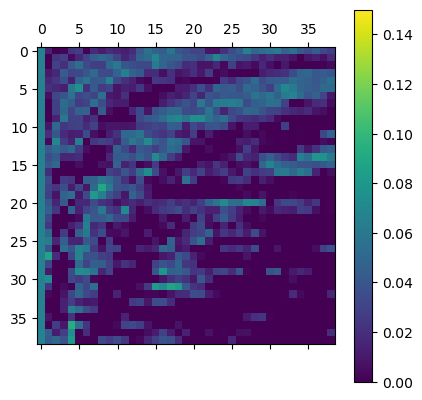

In [90]:
plt.matshow(res[0,0].reshape(39,39),vmin=0,vmax=0.15)
plt.colorbar()